A few references:

* [ARVIZ API](https://python.arviz.org/en/latest/api/index.html)
* [PYMC API](https://www.pymc.io/projects/docs/en/stable/api.html)
* [xarray API](https://docs.xarray.dev/en/stable/api.html)
* [daft](https://docs.daft-pgm.org/en/latest/): &nbsp; [daft & complete pooling](https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer#41_complete_pooling_model)
* [graphviz](https://graphviz.readthedocs.io/en/stable/api.html): &nbsp; [pymc.model_to_graphviz](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.model_to_graphviz.html), <a href="https://www.pymc.io/projects/docs/en/stable/_modules/pymc/model_graph.html#:~:text=VarName%22%2C%20str)%0A%0A%0Aclass-,ModelGraph,-%3A%0A%20%20%20%20def%20__init__(self"> pymc.model_graph.ModelGraph</a>

<br>

# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [4]:
%matplotlib inline

In [5]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

Versions

In [6]:
az.__version__

'0.13.0'

In [7]:
pm.__version__

'4.3.0'

In [8]:
np.__version__

'1.22.3'

<br>

## Custom

In [9]:
import src.graphics.settings
import src.graphics.sketch
import src.graphics.models

import src.data.radioactivity
import src.data.features
import src.data.coordinates

import src.models.complete
import src.models.unpooled
import src.models.inference
import src.models.mapping

<br>

Aesthetics

In [10]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures
* The `Labels` class is for `sketch.annotation(ax, Labels(title='...', xlabel='...', ylabel='...'))`

In [11]:
sketch = src.graphics.sketch.Sketch()
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

For the DAG (directed acyclic graph) of models

In [12]:
path = os.path.join(os.getcwd(), 'notebooks')
dag = src.graphics.models.Models(path=path)

<br>

## Settings

Seed

In [13]:
RANDOM_SEED = 8924

<br>

Graphing

In [14]:
az.style.use('arviz-darkgrid')

<br>

## Logging

In [15]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

Excerpt: Focusing on Minnesota, MN, dwellings.

In [16]:
excerpt = src.data.radioactivity.Radioactivity().exc(state='MN')
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm'],
      dtype='object')
2022-11-27 18:21:45.409


# of instances: (919, 27)
2022-11-27 18:21:45.411


# of unique codes: (919,)
2022-11-27 18:21:45.412



<br>

Extra features

In [17]:
excerpt = src.data.features.Features().exc(data=excerpt)
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm', 'ln_radon',
       'countyindex'],
      dtype='object')
2022-11-27 18:21:45.454


# of instances: (919, 29)
2022-11-27 18:21:45.456


# of unique codes: (919,)
2022-11-27 18:21:45.457



<br>

Frequencies

In [18]:
frequencies = excerpt[['county', 'countyindex', 'floor']].groupby(by=['county', 'countyindex', 'floor']).value_counts()
frequencies.rename('N', inplace=True)
frequencies = frequencies.to_frame()
frequencies.reset_index(drop=False, inplace=True)
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-11-27 18:21:45.477



<br>
<br>

# Exploratory Graphs

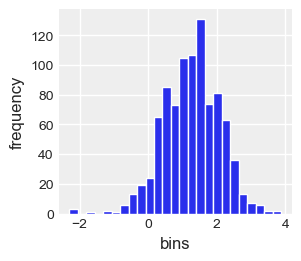

In [19]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Models

## Complete

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*, i.e., basement or ground level.
* The dependent variable is *ln(radon)*
* Is the *intercept* implicit below?



<br>

### Model

The model's initial co$\ddot{o}$rdinates

In [20]:
coords = src.data.coordinates.Coordinates(data=excerpt).exc()
logger.info(coords)


{'Level': {'Basement': 0, 'Ground': 1}, 'County': {'AITKIN': 0, 'ANOKA': 1, 'BECKER': 2, 'BELTRAMI': 3, 'BENTON': 4, 'BIG STONE': 5, 'BLUE EARTH': 6, 'BROWN': 7, 'CARLTON': 8, 'CARVER': 9, 'CASS': 10, 'CHIPPEWA': 11, 'CHISAGO': 12, 'CLAY': 13, 'CLEARWATER': 14, 'COOK': 15, 'COTTONWOOD': 16, 'CROW WING': 17, 'DAKOTA': 18, 'DODGE': 19, 'DOUGLAS': 20, 'FARIBAULT': 21, 'FILLMORE': 22, 'FREEBORN': 23, 'GOODHUE': 24, 'HENNEPIN': 25, 'HOUSTON': 26, 'HUBBARD': 27, 'ISANTI': 28, 'ITASCA': 29, 'JACKSON': 30, 'KANABEC': 31, 'KANDIYOHI': 32, 'KITTSON': 33, 'KOOCHICHING': 34, 'LAC QUI PARLE': 35, 'LAKE': 36, 'LAKE OF THE WOODS': 37, 'LE SUEUR': 38, 'LINCOLN': 39, 'LYON': 40, 'MAHNOMEN': 41, 'MARSHALL': 42, 'MARTIN': 43, 'MCLEOD': 44, 'MEEKER': 45, 'MILLE LACS': 46, 'MORRISON': 47, 'MOWER': 48, 'MURRAY': 49, 'NICOLLET': 50, 'NOBLES': 51, 'NORMAN': 52, 'OLMSTED': 53, 'OTTER TAIL': 54, 'PENNINGTON': 55, 'PINE': 56, 'PIPESTONE': 57, 'POLK': 58, 'POPE': 59, 'RAMSEY': 60, 'REDWOOD': 61, 'RENVILLE': 62, 

<br>

The model

In [21]:
complete = src.models.complete.Complete(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The # of level group elements: (2,)
2022-11-27 18:21:48.115


The shape of mu, whereby mu = measures[levelcode]: (919,)
2022-11-27 18:21:48.160


y
2022-11-27 18:21:48.183



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(complete)`

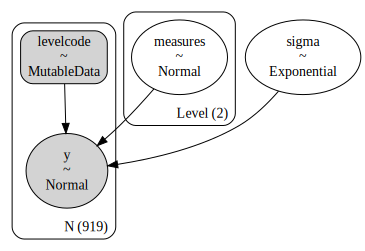

In [22]:
name = 'complete.gv'
dag.exc(model=complete, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [23]:
evidence = src.models.inference.Inference(model=complete).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-11-27 18:21:49.627

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-11-27 18:21:49.628

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-11-27 18:21:52.898

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-11-27 18:21:52.900



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
2022-11-27 18:22:23.637

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-11-27 18:22:29.910

Sampling: [y]

Sampling: [y]
2022-11-27 18:22:30.079



In [24]:
evidence = src.models.mapping.Mapping(inferences=evidence, coords=coords).exc()

In [25]:
evidence

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Prior Measures

<br>

**Prior Measures: Distributions**



In [26]:
computations = []

for k, v in coords['Level'].items():
    
    points = evidence.prior['measures'].sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.head())


    measures  level      type
0   9.198471      0  Basement
1  13.107947      0  Basement
2 -12.175881      0  Basement
3  -7.218295      0  Basement
4  -2.243466      0  Basement
2022-11-27 18:22:31.133



<br>

The graph

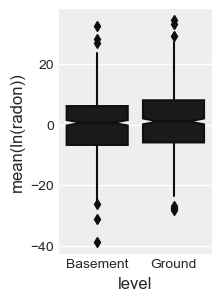

In [27]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

### Prior Predictive

In [28]:
evidence.prior_predictive

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, N: 919)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * N        (N) int32 0 1 2 3 4 5 6 7 8 ... 910 911 912 913 914 915 916 917 918
Data variables:
    y        (chain, draw, N) float64 -10.33 8.192 10.56 ... 1.186 -0.9823 1.836
Attributes:
    created_at:                 2022-11-27T18:22:30.032818
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<br>
<br>

### Posterior Measures


Notes/references:

* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`


<br>

**Posterior Measures: Distributions**

In [29]:
computations = []

for k, v in coords['Level'].items():
    
    points = evidence.posterior['measures'].mean(dim=('chain')).sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.tail())


      measures  level    type
1995  0.718822      1  Ground
1996  0.801899      1  Ground
1997  0.765469      1  Ground
1998  0.792146      1  Ground
1999  0.781532      1  Ground
2022-11-27 18:22:31.527



<br>

The distributions

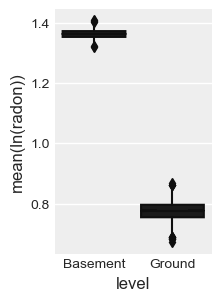

In [30]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

**Posterior Measures & Standard Deviations: Summaries**

In [31]:
az.summary(evidence)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
measures[Basement],1.362,0.028,1.310,1.414,0.000,0.000,5277.0,3100.0,1.0
measures[Ground],0.775,0.063,0.657,0.892,0.001,0.001,5630.0,3140.0,1.0
sigma,0.791,0.019,0.757,0.828,0.000,0.000,6256.0,3087.0,1.0


<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

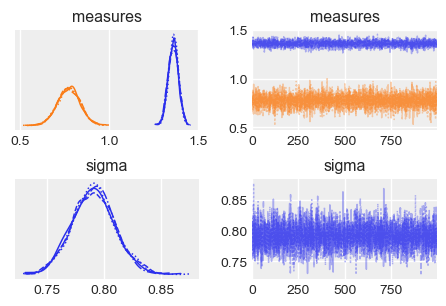

In [32]:
with complete:
    az.plot_trace(data=evidence, figsize=(4.35, 2.95))

<br>

Cf.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000137E3D90>,
      dtype=object)

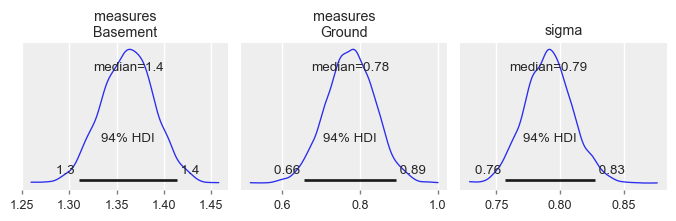

In [33]:
pm.plot_posterior(data=evidence, var_names=['measures', 'sigma'], 
                 figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

**Posterior Measures Mean**

In [34]:
averages_features = evidence.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    measures   (Level) float64 1.362 0.7751
    sigma      float64 0.7912

<br>

**Posterior Measures High Density Intervals**

Herein, determining the high density posterior intervals via

> ```python
hdi_features = (
    trace.posterior['measures'].groupby(trace.posterior.LevelName).apply(
        lambda x: az.hdi(x, input_core_dims=[['chain', 'draw']]))['measures']
)
hdi_features


is unnecessarily complex, and the resulting object does not include `LevelCode` co$\ddot{o}$rdinates.

<br>


In [35]:
hdi_features = az.hdi(evidence)
hdi_features

<xarray.Dataset>
Dimensions:    (Level: 2, hdi: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    measures   (Level, hdi) float64 1.31 1.414 0.6571 0.8919
    sigma      (hdi) float64 0.7566 0.8277

<br>
<br>

### Posterior Predictive

<br>

**Posterior Predictive Check**

Equivalent:
> ```python 
pm.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

> ```python 
az.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

<br>

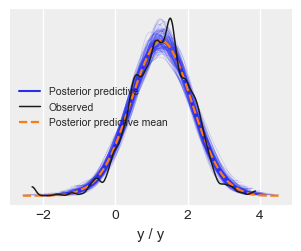

In [36]:
az.plot_ppc(data=evidence, figsize=(2.9, 2.4), num_pp_samples=125, random_seed=RANDOM_SEED, textsize=10)

<br>
<br>

**The posterior predictive high density interval per floor level type**

In [37]:
credibility = lambda x: az.hdi(x, input_core_dims=[["chain", "draw", "N"]])
hdi_predictive = (
    evidence.posterior_predictive.y.groupby(evidence.constant_data.levelcode)
    .apply(credibility)
    .y
)
hdi_predictive

<xarray.DataArray 'y' (levelcode: 2, hdi: 2)>
array([[-0.11502589,  2.86231146],
       [-0.70959972,  2.2784894 ]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * levelcode  (levelcode) int64 0 1

<br>

### Graphs

Options:

* `sns.scatterplot(y=evidence.observed_data['y'], x=trace.observed_data['LevelName'], ax=ax)`

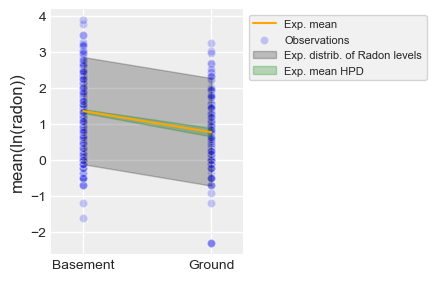

In [38]:
ax = sketch.figure(width=4.25, height=2.7)

evidence.observed_data.plot.scatter(x='LevelCode', y='y', label='Observations', alpha=0.25, ax=ax)

az.plot_hdi(hdi_predictive.levelcode.values, 
            hdi_data=hdi_predictive, 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. distrib. of Radon levels'}, 
            color='k',
            ax=ax)

az.plot_hdi(hdi_features.LevelCode.values, 
            hdi_data=hdi_features['measures'], 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. mean HPD'}, 
            color='green',
            ax=ax)

ax.plot(np.arange(averages_features.coords['Level'].shape[0]), 
        averages_features['measures'].values, 
        color='orange',
        label='Exp. mean')

sketch.annotation(ax, Labels(title='', xlabel='', ylabel='mean(ln(radon))'))

ax.set_xlim(-0.25, 1.25)

ax.set_xticks(evidence.posterior['LevelCode'].values)
ax.set_xticklabels(evidence.posterior['Level'].values, rotation=0)

ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(1, 1), loc='upper left')

<br>

### Inference Data

In [39]:
evidence

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

## Unpooled

<br>

The object `coords` has the set of distinct counties, each has a distinct index; ref. `coords['County']`.  &nbsp; In future use [an appropriate geographic code](https://www.nist.gov/system/files/documents/2021/08/11/FIPSCodesReplacementChart2015.pdf). &nbsp;  Additionally, the data object `excerpt` includes a `countyindex` field, whereby the relevant dictionary is $\rightarrow$ `coords['County']`.

> ```python
logger.info(coords.keys())
logger.info(coords.get('County'))
```


<br>

### Model

In [40]:
unpooled = src.models.unpooled.Unpooled(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The county & level groups: (85, 2)
2022-11-27 18:22:40.266


The shape of mu, whereby mu = measures[countyindex, levelcode]: (919,)
2022-11-27 18:22:40.301


y
2022-11-27 18:22:40.321



<br>
<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(unpooled)`

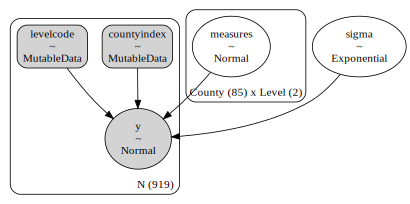

In [41]:
name = 'unpooled.gv'
dag.exc(model=unpooled, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [42]:
alternative = src.models.inference.Inference(model=unpooled).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-11-27 18:22:41.836

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-11-27 18:22:41.838

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-11-27 18:22:45.262

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-11-27 18:22:45.266



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
2022-11-27 18:23:36.634

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-11-27 18:23:43.395

Sampling: [y]

Sampling: [y]
2022-11-27 18:23:43.570



<br>
<br>

### Posterior Measures

<br>

**Posterior Measures & Standard Deviations: Summaries**

In [43]:
az.summary(alternative)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"measures[AITKIN, Basement]",0.669,0.411,-0.131,1.382,0.006,0.005,5468.0,2902.0,1.0
"measures[AITKIN, Ground]",0.822,0.689,-0.445,2.102,0.010,0.008,4338.0,2416.0,1.0
"measures[ANOKA, Basement]",0.953,0.101,0.758,1.141,0.001,0.001,5721.0,3202.0,1.0
"measures[ANOKA, Ground]",-0.135,0.416,-0.886,0.681,0.006,0.006,4600.0,2969.0,1.0
"measures[BECKER, Basement]",1.469,0.696,0.117,2.763,0.010,0.008,4658.0,2691.0,1.0
...,...,...,...,...,...,...,...,...,...
"measures[WRIGHT, Basement]",1.676,0.208,1.290,2.067,0.003,0.002,4121.0,2814.0,1.0
"measures[WRIGHT, Ground]",0.862,0.711,-0.483,2.200,0.010,0.009,4760.0,3059.0,1.0
"measures[YELLOW MEDICINE, Basement]",1.217,0.512,0.252,2.227,0.007,0.005,5468.0,2960.0,1.0
"measures[YELLOW MEDICINE, Ground]",0.010,10.297,-19.198,19.391,0.150,0.178,4730.0,2876.0,1.0


<br>

<br>

**Posterior Measures & Standard Deviations: Graphs**

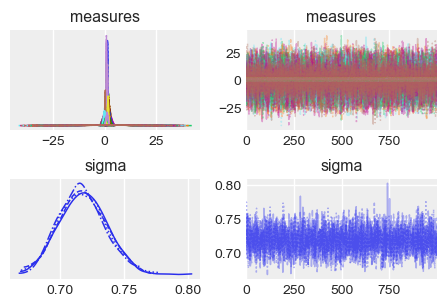

In [44]:
with unpooled:
    az.plot_trace(data=alternative, figsize=(4.35, 2.95))

<br>
<br>

**Posterior Measures: High Density Intervals**

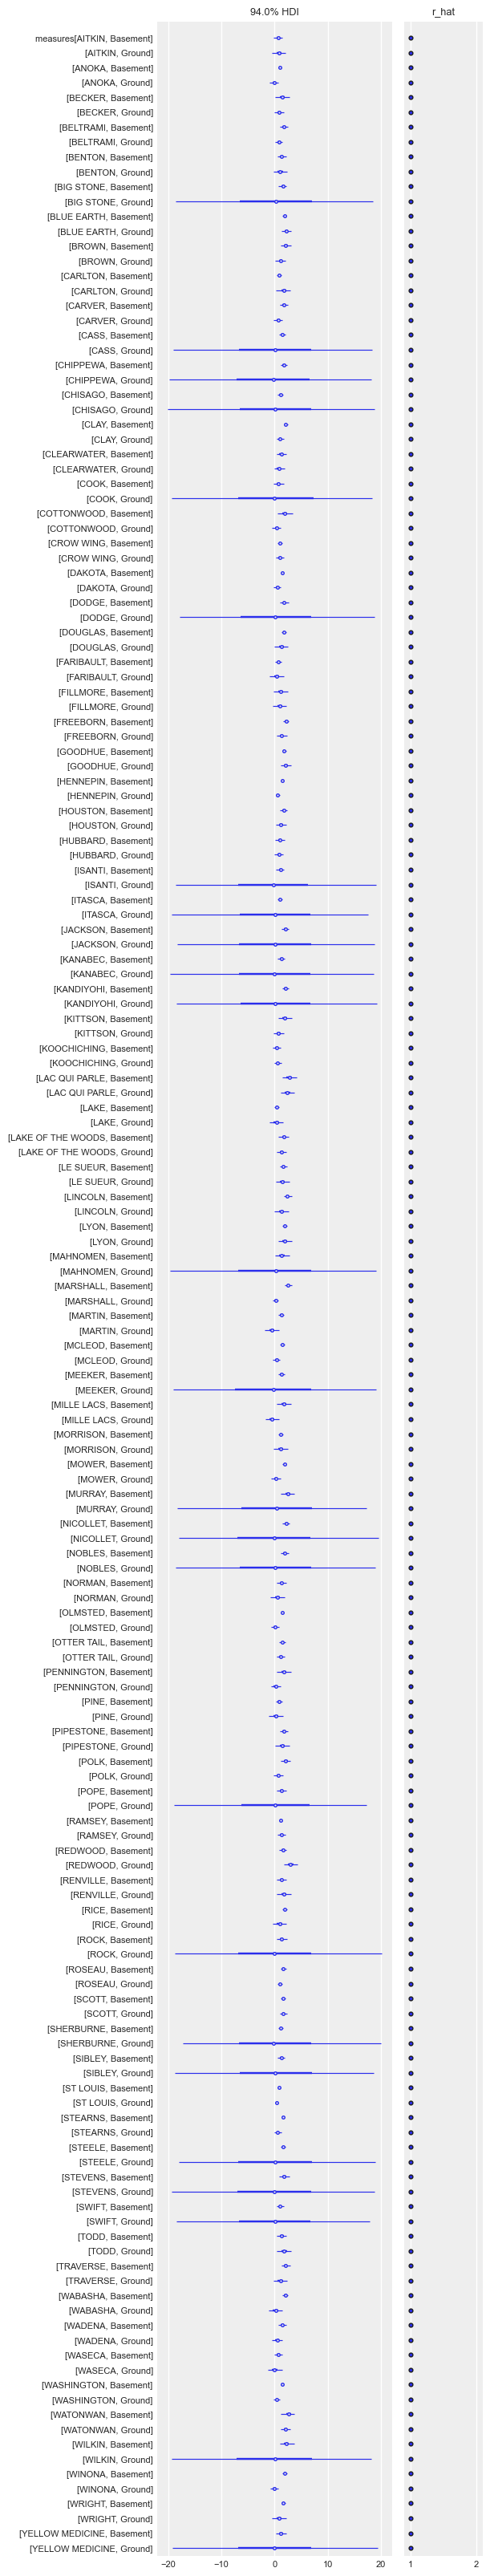

In [45]:
az.plot_forest(
    alternative, var_names='measures', figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

<br>

**Posterior Mean**

In [46]:
averages_features = alternative.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:   (County: 85, Level: 2)
Coordinates:
  * County    (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level     (Level) <U8 'Basement' 'Ground'
Data variables:
    measures  (County, Level) float64 0.6694 0.8217 0.9526 ... 1.217 0.01006
    sigma     float64 0.7178

<br>

**Posterior Check**

In [47]:
hdi_features = az.hdi(alternative)
hdi_features

<xarray.Dataset>
Dimensions:   (County: 85, Level: 2, hdi: 2)
Coordinates:
  * County    (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level     (Level) <U8 'Basement' 'Ground'
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    measures  (County, Level, hdi) float64 -0.1314 1.382 -0.4445 ... -19.2 19.39
    sigma     (hdi) float64 0.6852 0.7521

<br>
<br>

### Graphs

<br>
<br>

**High Density Intervals, Averages**

For more about `sel(.)` visit [arviz.InferenceData.sel(.)](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.sel.html).  &nbsp; The # of counties is

> ```python 
len(coords.get('County'))


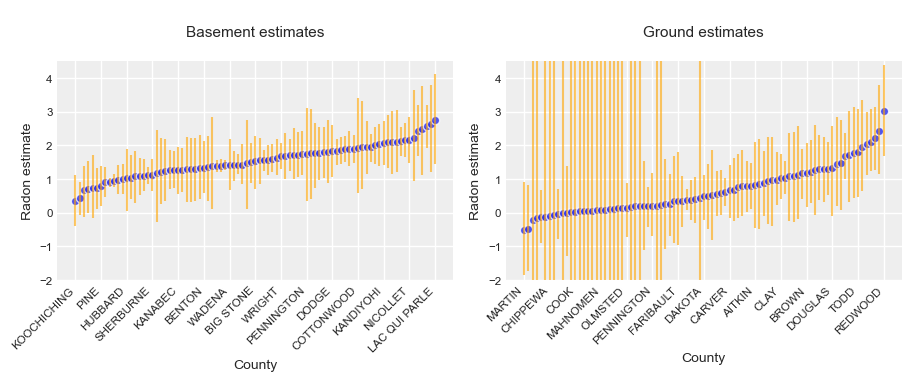

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.7))

xticks = np.arange(0, 86, 6)

fontdict = {'horizontalalignment': 'right', 'fontsize': 8}

for ax, level in zip(axes, ['Basement', 'Ground']):
    
    averages_ = averages_features.sel(Level=level).sortby('measures')
    hdi_ = hdi_features.sel(Level=level).sortby(averages_.measures)
    averages_.plot.scatter(x='County', y='measures', ax=ax, alpha=0.8)
    
    
    # high density interval lines
    ax.vlines(
        np.arange(len(coords.get('County'))),
        hdi_.measures.sel(hdi='lower'),
        hdi_.measures.sel(hdi='higher'),
        color='orange',
        alpha=0.6,
    )
    
    
    # titles
    ax.set_title(f'\n{level.title()} estimates\n', fontsize=11)
    
    # x ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(averages_.County.values[xticks], horizontalalignment='right', rotation=45)
    
    # all ticks
    ax.tick_params(labelsize='x-small')
    
    # limits
    ax.set_ylim(bottom=-2, top=4.5)
    
    # labels
    ax.set_xlabel('County', fontsize=10)
    ax.set_ylabel('Radon estimate', fontsize=10)

<br>
<br>

**Ground Level Dispersions of High Density Intervals**

Ground level posterior `measures`  high density interval data

In [49]:
experiment = hdi_features['measures'].sel(Level='Ground')

<br>

Hence, the differences and their parallel county names

In [50]:
differences = pd.DataFrame(data={'difference': experiment.sel(hdi='higher') - experiment.sel(hdi='lower'), 
                                 'county': experiment['County']})

<br>

Differences and frequencies.

In [51]:
values = frequencies.loc[frequencies['floor'] == coords['Level']['Ground'], ]
dispersions = differences.merge(values, how='left', on='county')
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.851041         WATONWAN         80.0    1.0  2.0
81   37.544650           WILKIN          NaN    NaN  NaN
82    1.500895           WINONA         82.0    1.0  3.0
83    2.683661           WRIGHT         83.0    1.0  1.0
84   38.588157  YELLOW MEDICINE          NaN    NaN  NaN
2022-11-27 18:24:17.685



<br>

Some counties do not have any ground level data points

In [52]:
dispersions.loc[:, 'N'] = dispersions['N'].fillna(value=0).array
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.851041         WATONWAN         80.0    1.0  2.0
81   37.544650           WILKIN          NaN    NaN  0.0
82    1.500895           WINONA         82.0    1.0  3.0
83    2.683661           WRIGHT         83.0    1.0  1.0
84   38.588157  YELLOW MEDICINE          NaN    NaN  0.0
2022-11-27 18:24:17.698



<br>

The graph below illustrates that the large dispersions, intervals, are due counties that do not have data points.

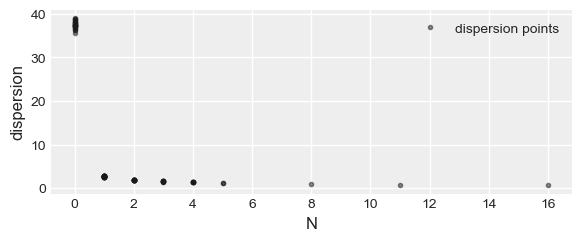

In [53]:
ax = sketch.figure(width=5.7, height=2.3)

ax.plot(dispersions['N'].array, dispersions['difference'].array, 'ok', markersize=3, alpha=0.5, label='dispersion points');
sketch.annotation(ax, Labels(title='', xlabel='N', ylabel='dispersion'))
ax.legend(loc='upper right', fontsize='small');

<br>
<br>

**Funnel**